<h1>Laptop price prediction</h1>

<h2>Dataset</h2>

The dataset comes from the kaggle website. <a href='https://www.kaggle.com/muhammetvarl/laptop-price?fbclid=IwAR0u_aniXOzXS7nsFdz_BiKnhl0imABQZpettQMX4EO2BWDFRg2_8XIGWNQ'>LINK</a>

The dataset contains variables such as:

<table>
<tbody>
<tr>
<td>&nbsp;<b>Variable</b></td>
<td><b>Description</b>&nbsp;</td>
</tr>
<tr>
<td>Price_euros</td>
<td>&nbsp;Laptop price in euro</td>
</tr>
<tr>
<td>&nbsp;Company</td>
<td>&nbsp;Laptop Manufacturer</td>
</tr>
<tr>
<td>&nbsp;Product&nbsp;</td>
<td>&nbsp;Brand and Model</td>
</tr>
<tr>
<td>&nbsp;TypeName&nbsp;</td>
<td>&nbsp;Type (Notebook, Ultrabook, Gaming, etc.)</td>
</tr>
<tr>
<td>&nbsp;Inches</td>
<td>&nbsp;Screen Size</td>
</tr>
<tr>
<td>&nbsp;ScreenResolution</td>
<td>&nbsp;Screen Resolution</td>
</tr>
<tr>
<td>&nbsp;Cpu</td>
<td>&nbsp;Central Processing Unit (CPU)</td>
</tr>
<tr>
<td>&nbsp;Ram&nbsp;</td>
<td>&nbsp;Laptop RAM</td>
</tr>
<tr>
<td>&nbsp;Memory</td>
<td>&nbsp;Hard Disk / SSD Memory</td>
</tr>
<tr>
<td>&nbsp;GPU</td>
<td>&nbsp;Graphics Processing Units (GPU)</td>
</tr>
<tr>
<td>&nbsp;OpSys</td>
<td>&nbsp;Operating System</td>
</tr>
<tr>
<td>&nbsp;Weight</td>
<td>&nbsp;Laptop Weight</td>
</tr>
</tbody>
</table>


In [ ]:
#import of libraries
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

In [ ]:
#loading the database
df = pd.read_csv('laptop_price.csv').drop(columns=['laptop_ID'])

In [ ]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


The dataset contains a lot of string variables. To prepare the data for analysis, the following steps were taken:
1. Removed letters from Ram and Weight variables
2. Based on the variable Memory, 4 variables describing the type and size of the hard disk were created (SSD_size, HDD_size, Hybrid_size, Flash_size)
3. The screen_height and screen_width variables were created from the ScreenResolution variable to describe the vertical and horizontal screen resolution
4. Only the manufacturer name is left in the CPU variable. Created a GHz variable to describe the gigahertz of the processor in the laptop
5. For Opsys and company, created "other" category for observations which are the least in the set. All versions of windows were compiled into a single category of observation

In [ ]:
#Remove letters from Ram and Weight variables
df['Ram'] = df['Ram'].map(lambda x: x.lstrip('+-').rstrip('GB'))
df['Weight'] = df['Weight'].map(lambda x: x.lstrip('+-').rstrip('kg'))

#4 variables describing the type and size of the hard disk
df['SSD_size'] = 0
df['HDD_size'] = 0
df['FS_size'] = 0
df['Hybrid_size'] = 0

for x in range(0, len(df)):
    for y in df['Memory'][x].split('+'):
        if 'SSD' in y:
            if 'TB' in y:
                df['SSD_size'][x] = float(''.join(re.findall('\d+', y)))*1000
            else:
                df['SSD_size'][x] = float(''.join(re.findall('\d+', y)))
        elif 'HDD' in y:
            if 'TB' in y:
                df['HDD_size'][x] = float(''.join(re.findall('\d+', y)))*1000
            else:
                df['HDD_size'][x] = float(''.join(re.findall('\d+', y)))
        elif 'Flash Storage' in y:
            if 'TB' in y:
                df['FS_size'][x] = float(''.join(re.findall('\d+', y)))*1000
            else:
                df['FS_size'][x] = float(''.join(re.findall('\d+', y)))
        else:
            if 'TB' in y:
                df['Hybrid_size'][x] = float(''.join(re.findall('\d+', y)))*1000
            else:
                df['Hybrid_size'][x] = float(''.join(re.findall('\d+', y)))
                
df['screen'] = np.nan
df['screen_width'] = np.nan
df['screen_height'] = np.nan

# screen_height and screen_width
for x in range(0, len(df)):

    df['screen'][x] = re.findall('([0-9]*)x([0-9]*)', df['ScreenResolution'][x])
    df['screen_width'][x] = df['screen'][x][0][0]
    df['screen_height'][x] = df['screen'][x][0][1]

df['GHz']=np.nan
for x in range(0, len(df)):
    df['GHz'][x] = re.findall('([0-9][.0-9]*)+GHz', df['Cpu'][x])[0]
    
df['Cpu'].replace({'.*[I][n][t][e][l].*': 'Intel',
                     '.*[A][M][D].*': 'AMD'
                     }, regex=True, inplace=True)

df['Gpu'].replace({'.*[I][n][t][e][l].*': 'Intel',
                     '.*[A][M][D].*': 'AMD',
                   '.*[N][v][i].*': 'Nvidia',
                     }, regex=True,inplace=True)

df['OpSys'].replace({'.*[W][i][n][d][o].*': 'Windows',
                     '.*[M][a][c].*': 'MacOs',
                     '.*[m][a][c].*': 'MacOs',
                    '.*[A][n][d].*': 'Other',
                     '.*[C][h][r].*': 'Other',
                     }, regex=True, inplace=True)

df['Company_int'] = np.nan

for x in range(0, len(df)):
    if df['Company'][x] == 'Lenovo':
        df['Company_int'][x] = 'Lenovo'
    elif df['Company'][x] == 'Dell':
        df['Company_int'][x] ='Dell'
    elif df['Company'][x] == 'HP':
        df['Company_int'][x] = 'HP'
    elif df['Company'][x] == 'Asus':
        df['Company_int'][x] = 'Asus'
    elif df['Company_int'][x] == 'Acer':
        df['Company'][x] = 'Acer'
    elif df['Company'][x] == 'Toshiba':
        df['Company_int'][x] = 'Toshiba'
    elif df['Company'][x] == 'Apple':
        df['Company_int'][x] = 'Apple'
    else:
        df['Company_int'][x] = 'Other'
        

In [ ]:
df['Company'] = df['Company_int']
df.drop(columns=['Product', 'ScreenResolution', 'Memory', 'screen', 'Company_int'], inplace=True)

<h2>Data Analysis<h2>

In [ ]:
#Function to create a bar plot with percentages
def barplots(title, variable, data, width=12, height=8, text_rot=0):
    plt.figure(figsize=(width,height))
    plt.title(title)
    plt.ylabel('Procenty')

    ax = (data[variable].value_counts()/len(data)*100).sort_index().plot(kind="bar", rot=text_rot)
    ax.set_yticks(np.arange(0, 110, 10))

    ax2 = ax.twinx()
    ax2.set_yticks(np.arange(0, 110, 10)*len(df)/100)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
        
        
    return plt

In [ ]:
df.describe()

,Inches,Price_euros,SSD_size,HDD_size,FS_size,Hybrid_size,screen_width,screen_height,GHz
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,15.017191,1123.686992,182.554106,419.923254,4.555641,84.810437,1894.784344,1070.830391,2.298772
std,1.426304,699.009043,184.607784,578.514571,30.274090,915.343620,494.641028,284.519410,0.506340
min,10.100000,174.000000,0.000000,0.000000,0.000000,0.000000,1366.000000,768.000000,0.900000
25%,14.000000,599.000000,0.000000,0.000000,0.000000,0.000000,1600.000000,900.000000,2.000000
50%,15.600000,977.000000,256.000000,0.000000,0.000000,0.000000,1920.000000,1080.000000,2.500000
75%,15.600000,1487.880000,256.000000,1000.000000,0.000000,0.000000,1920.000000,1080.000000,2.700000
max,18.400000,6099.000000,1000.000000,10000.000000,512.000000,10000.000000,3840.000000,2160.000000,3.600000


<module 'matplotlib.pyplot' from 'C:\\Users\\Robert\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

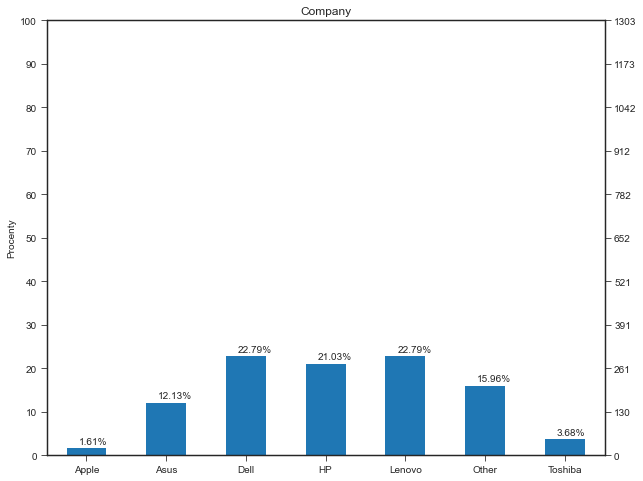

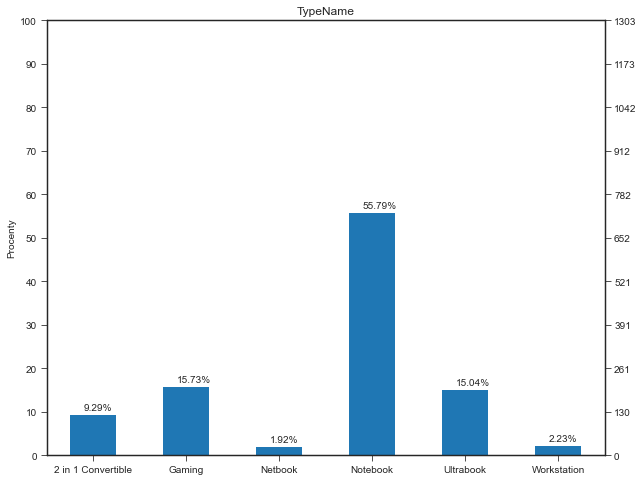

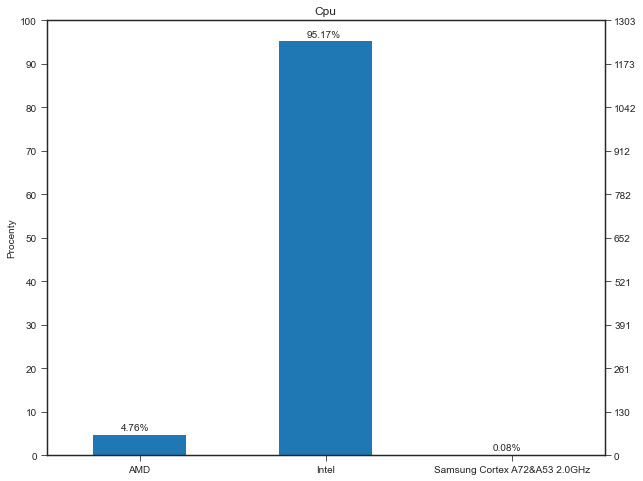

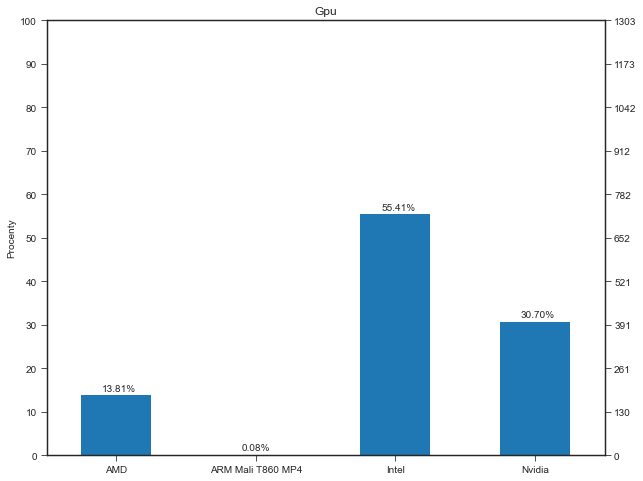

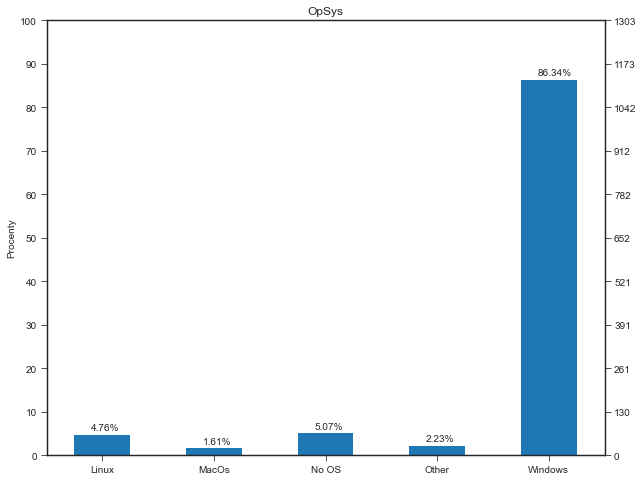

In [ ]:
barplots('Company', 'Company', df, width=10)
barplots('TypeName', 'TypeName', df, width=10)
barplots('Cpu', 'Cpu', df, width=10)
barplots('Gpu', 'Gpu', df, width=10)
barplots('OpSys', 'OpSys', df, width=10)

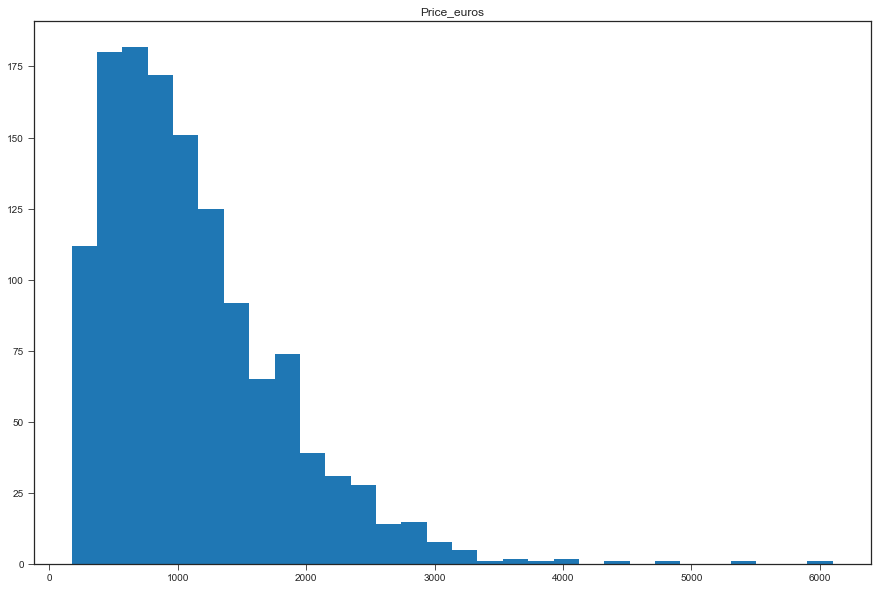

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(df['Price_euros'], bins=30)
plt.title('Price_euros')
plt.show()

Lenovo and Dell laptops make up the largest portion of the dataset. Of all the laptop types, the largest percentage (55.79%) are regular notebooks. Most processors are Intel processor. There is one observation having samsung processor. Also graphics cards from Intel. One graphics card belongs to ATM. It is the same observation with samsung processor. The observation having this processor and graphics card is removed from the dataset. Price has a right-skewed distribution. The price range is between 174 and 6099 dollars.

<h2>Data preparation for modeling</h2>

The first step of preparing data for modeling, is the above mentioned observation which has a different processor and graphics card. The next step will be to create a copy of the data, for neural networks. Then the string variables will be encoded into numeric variables. Categorical data for neural networks will be changed into dummy variables

In [ ]:
#drop observation with samsung CPU
df = df.loc[df['Cpu']!='Samsung Cortex A72&A53 2.0GHz']

In [ ]:
from sklearn import preprocessing


for variable in['Price_euros','Inches','Ram','Weight','SSD_size', 'HDD_size', 'FS_size', 'Hybrid_size', 'screen_height','screen_width', 'GHz']:
    df[variable] = df[variable].astype(float)
    
    
#copy dataset for neural network modelling
df_nn = df.copy()

#Encode categorical variables
for variable in ['Company', 'TypeName', 'Cpu', 'Gpu', 'OpSys']:
    le = preprocessing.LabelEncoder()
    le.fit(df[variable])
    df[variable] = le.transform(df[variable])
    df[variable] = df[variable].astype(int)

df.head(5)

,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,SSD_size,HDD_size,FS_size,Hybrid_size,screen_width,screen_height,GHz
0,0,4,13.3,1,8.0,1,1,1.37,1339.69,128.0,0.0,0.0,0.0,2560.0,1600.0,2.3
1,0,4,13.3,1,8.0,1,1,1.34,898.94,0.0,0.0,128.0,0.0,1440.0,900.0,1.8
2,3,3,15.6,1,8.0,1,2,1.86,575.00,256.0,0.0,0.0,0.0,1920.0,1080.0,2.5
3,0,4,15.4,1,16.0,0,1,1.83,2537.45,512.0,0.0,0.0,0.0,2880.0,1800.0,2.7
4,0,4,13.3,1,8.0,1,1,1.37,1803.60,256.0,0.0,0.0,0.0,2560.0,1600.0,3.1


In [ ]:
#Create dummy variables
df_nn = pd.get_dummies(df_nn, drop_first=True)
df_nn.head(5)

,Inches,Ram,Weight,Price_euros,SSD_size,HDD_size,FS_size,Hybrid_size,screen_width,screen_height,...,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,Cpu_Intel,Gpu_Intel,Gpu_Nvidia,OpSys_MacOs,OpSys_No OS,OpSys_Other,OpSys_Windows
0,13.3,8.0,1.37,1339.69,128.0,0.0,0.0,0.0,2560.0,1600.0,...,0,1,0,1,1,0,1,0,0,0
1,13.3,8.0,1.34,898.94,0.0,0.0,128.0,0.0,1440.0,900.0,...,0,1,0,1,1,0,1,0,0,0
2,15.6,8.0,1.86,575.00,256.0,0.0,0.0,0.0,1920.0,1080.0,...,1,0,0,1,1,0,0,1,0,0
3,15.4,16.0,1.83,2537.45,512.0,0.0,0.0,0.0,2880.0,1800.0,...,0,1,0,1,0,0,1,0,0,0
4,13.3,8.0,1.37,1803.60,256.0,0.0,0.0,0.0,2560.0,1600.0,...,0,1,0,1,1,0,1,0,0,0


Next, a list of explanatory variables was created and the name of the explanatory variable was assigned to the target variable

In [ ]:
features = list(df.columns)
features.remove('Price_euros')
target = 'Price_euros'

In [ ]:
#Prepare data for results
results = pd.DataFrame()

<h2>Modelling</h2>

Five-fold cross-validation was used for all models created. 
Shuffling of variables was also used. MSE, MAE and RMSE metrics will be calculated for the models.<br>
Models will be made in the study:
<ul>
    <li>Random Forest</li>
    <li>Extra Trees</li>
    <li>XGBoost</li>
    <li>Feed Forward Neural Networks</li>
</ul>

<h2>Random Forest</h2>

In [ ]:
#import libraries
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
#wrapper
def CVTestRFRegress(nFolds = 5, randomState=2022, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    #lists for collecting results from models
    MAE_testResults = []
    MSE_testResults = []
    RMSE_testResults = []
    MAE_trainResults = []
    MSE_trainResults = []
    RMSE_trainResults = []
    
    # list with prediction values
    predictions = []

    indices = []
    
    # Cross-validation loop
    for train, test in kf.split(df.index.values):
        # Prepare estimator
        reg = RandomForestRegressor(*args, **kwargs, n_jobs=-1)
        
        #Training model
        reg.fit(df.iloc[train][features], df.iloc[train][target])

        # Predictions on test and training sets
        predsTrain = reg.predict(df.iloc[train][features])
        preds = reg.predict(df.iloc[test][features])

        # Informations of predictions in this set
        predictions.append(preds.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())

        # Counting metrics: MAE, MSE, RMSE 
        MAE_train = mean_absolute_error(df[target].iloc[train], predsTrain)
        MAE_test = mean_absolute_error(df[target].iloc[test], preds)
        MSE_train = mean_squared_error(df[target].iloc[train], predsTrain)
        MSE_test = mean_squared_error(df[target].iloc[test], preds)
        RMSE_train = np.log(mean_squared_error(df[target].iloc[train], predsTrain))
        RMSE_test = np.log(mean_squared_error(df[target].iloc[test], preds))


        # Saving resutls to list 
        MAE_trainResults.append(MAE_train) 
        MAE_testResults.append(MAE_test)
        MSE_trainResults.append(MSE_train) 
        MSE_testResults.append(MSE_test)    
        RMSE_trainResults.append(RMSE_train) 
        RMSE_testResults.append(RMSE_test)
        
        #features importance
        imp = reg.feature_importances_

        
    return MAE_trainResults, MAE_testResults,MSE_trainResults,MSE_testResults,RMSE_trainResults, RMSE_testResults ,predictions, indices, imp


In [ ]:
import random 
results_RF={}
for x in range(100):
    n_estimators= int(random.randint(50,1000))
    #criterion = random.choice(['squared_error', 'poisson'])
    max_depth = random.randint(2,10)
    min_samples_split=random.randint(2,10) 
    min_samples_leaf=random.randint(1,10) 
    min_weight_fraction_leaf=round(random.uniform(0, 0.5),2)
    max_features=random.choice(['auto', 'sqrt', 'log2'])
    max_leaf_nodes=None
    min_impurity_decrease=round(random.uniform(0, 0.5),2)
    bootstrap=True
    oob_score=False 
    n_jobs=-1
    random_state=2021
    verbose=0
    warm_start=False 
    ccp_alpha=0.0
    max_samples=None
    
    MAE_trainResults, MAE_testResults,MSE_trainResults,MSE_testResults,RMSE_trainResults, RMSE_testResults ,predictions, indices, imp = CVTestRFRegress(
        max_depth=max_depth,
        #criterion = criterion,
        n_estimators = n_estimators,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        min_weight_fraction_leaf = min_weight_fraction_leaf,
        max_features = max_features,
        min_impurity_decrease = min_impurity_decrease,
        random_state = random_state,
        features=features)
        
    results_RF[np.mean(RMSE_testResults)] = {
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'min_weight_fraction_leaf': min_weight_fraction_leaf,
        'max_features': max_features,
        'min_impurity_decrease': min_impurity_decrease  
    }


In [ ]:
#Params of the best model by RMSE metric
print(min(results_RF.keys()))
print(results_RF[min(list(results_RF.keys()))])

11.52851589419571
{'max_depth': 9, 'n_estimators': 184, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.15}


In [ ]:
MAE_trainResults, MAE_testResults,MSE_trainResults,MSE_testResults,RMSE_trainResults, RMSE_testResults ,predictions, indices, imp = CVTestRFRegress(max_depth = 9,
                                                                                                                                                    n_estimators = 184,
                                                                                                                                                   min_samples_split=5,
                                                                                                                                                    min_samples_leaf=4,
                                                                                                                                                   min_impurity_decrease=0.15)

In [ ]:

fold1 = ['Random Forest', '1 Fold', MAE_trainResults[0], MAE_testResults[0],MSE_trainResults[0], MSE_testResults[0], RMSE_trainResults[0], RMSE_testResults[0]]
fold2 = ['Random Forest', '2 Fold', MAE_trainResults[1], MAE_testResults[1],MSE_trainResults[1], MSE_testResults[1], RMSE_trainResults[1], RMSE_testResults[1]]
fold3 = ['Random Forest', '3 Fold', MAE_trainResults[2], MAE_testResults[2],MSE_trainResults[2], MSE_testResults[2], RMSE_trainResults[2], RMSE_testResults[2]]
fold4 = ['Random Forest', '4 Fold', MAE_trainResults[3], MAE_testResults[0],MSE_trainResults[3], MSE_testResults[3], RMSE_trainResults[3], RMSE_testResults[3]]
fold5 = ['Random Forest', '5 Fold', MAE_trainResults[4], MAE_testResults[4],MSE_trainResults[4], MSE_testResults[4], RMSE_trainResults[4], RMSE_testResults[4]]
mean = ['Random Forest', 'Mean', np.mean(MAE_trainResults),  np.mean(MAE_testResults), np.mean(MSE_trainResults), np.mean(MSE_testResults), np.mean(RMSE_trainResults), np.mean(RMSE_testResults)]
df_results_RF = pd.DataFrame([fold1, fold2, fold3, fold4, fold5, mean], columns=['Model', 'Folds', 'MAE Train', 'MAE Test', 'MSE Train', 'RMSE Test', 'RMSE Train', 'RMSE Test'])
results = pd.concat([results, df_results_RF])

In [ ]:
df_results_RF.set_index('Model')

,Folds,MAE Train,MAE Test,MSE Train,RMSE Test,RMSE Train,RMSE Test
Model,,,,,,,
Random Forest,1 Fold,167.722876,228.359070,60296.560683,118318.564096,11.007030,11.681136
Random Forest,2 Fold,174.357112,198.298703,65524.059412,91980.372751,11.090173,11.429330
Random Forest,3 Fold,174.400718,188.770109,67682.879293,65521.886339,11.122589,11.090140
Random Forest,4 Fold,166.277616,228.359070,59008.251943,131969.017918,10.985433,11.790322
Random Forest,5 Fold,172.901435,193.868172,66584.713050,90917.943089,11.106230,11.417713
Random Forest,Mean,171.131952,209.553527,63819.292876,99741.556839,11.062291,11.481728


<BarContainer object of 15 artists>

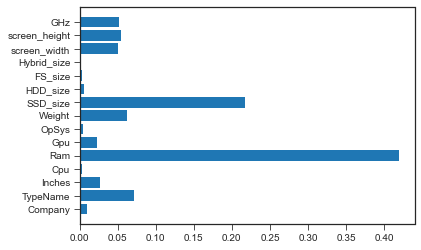

In [ ]:
plt.barh(features,imp)


<h2>Extra Trees<h2>

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
#wrapper
def CVTestETRegress(nFolds = 5, randomState=2022, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    #lists for collecting results from models
    MAE_testResults = []
    MSE_testResults = []
    RMSE_testResults = []
    MAE_trainResults = []
    MSE_trainResults = []
    RMSE_trainResults = []
    
    # list with prediction values
    predictions = []

    indices = []
    
    # Cross-validation loop
    for train, test in kf.split(df.index.values):
        # Prepare estimator
        reg = ExtraTreesRegressor(*args, **kwargs, n_jobs=-1)
        
        #Training model
        reg.fit(df.iloc[train][features], df.iloc[train][target])

        # Predictions on test and training sets
        predsTrain = reg.predict(df.iloc[train][features])
        preds = reg.predict(df.iloc[test][features])

        # Informations of predictions in this set
        predictions.append(preds.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())

        # Counting metrics: MAE, MSE, RMSE 
        MAE_train = mean_absolute_error(df[target].iloc[train], predsTrain)
        MAE_test = mean_absolute_error(df[target].iloc[test], preds)
        MSE_train = mean_squared_error(df[target].iloc[train], predsTrain)
        MSE_test = mean_squared_error(df[target].iloc[test], preds)
        RMSE_train = np.log(mean_squared_error(df[target].iloc[train], predsTrain))
        RMSE_test = np.log(mean_squared_error(df[target].iloc[test], preds))


        # Saving resutls to list 
        MAE_trainResults.append(MAE_train) 
        MAE_testResults.append(MAE_test)
        MSE_trainResults.append(MSE_train) 
        MSE_testResults.append(MSE_test)    
        RMSE_trainResults.append(RMSE_train) 
        RMSE_testResults.append(RMSE_test)
        
        #features importance
        imp = reg.feature_importances_

        
    return MAE_trainResults, MAE_testResults,MSE_trainResults,MSE_testResults,RMSE_trainResults, RMSE_testResults ,predictions, indices, imp


In [ ]:
import random 
results_ET={}
for x in range(100):
    n_estimators= int(random.randint(50,1000))
    #criterion = random.choice(['squared_error', 'poisson'])
    max_depth = random.randint(2,10)
    min_samples_split=random.randint(2,10) 
    min_samples_leaf=random.randint(1,10) 
    min_weight_fraction_leaf=round(random.uniform(0, 0.5),2)
    max_features=random.choice(['auto', 'sqrt', 'log2'])
    max_leaf_nodes=None
    min_impurity_decrease=round(random.uniform(0, 0.5),2)
    bootstrap=True
    oob_score=False 
    n_jobs=-1
    random_state=2021
    verbose=0
    warm_start=False 
    ccp_alpha=0.0
    max_samples=None
    
    MAE_trainResults, MAE_testResults,MSE_trainResults,MSE_testResults,RMSE_trainResults, RMSE_testResults ,predictions, indices, imp = CVTestETRegress(
        max_depth=max_depth,
        #criterion = criterion,
        n_estimators = n_estimators,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        min_weight_fraction_leaf = min_weight_fraction_leaf,
        max_features = max_features,
        min_impurity_decrease = min_impurity_decrease,
        random_state = random_state,
        features=features)
        
    results_ET[np.mean(RMSE_testResults)] = {
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'min_weight_fraction_leaf': min_weight_fraction_leaf,
        'max_features': max_features,
        'min_impurity_decrease': min_impurity_decrease  
    }


In [ ]:
#Params of the best model by RMSE metric
print(min(results_ET.keys()))
print(results_ET[min(list(results_ET.keys()))])

11.690218513650235
{'max_depth': 7, 'n_estimators': 565, 'min_samples_split': 6, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01, 'max_features': 'auto', 'min_impurity_decrease': 0.19}


In [ ]:
MAE_trainResults, MAE_testResults,MSE_trainResults,MSE_testResults,RMSE_trainResults, RMSE_testResults ,predictions, indices, imp = CVTestETRegress(max_depth = 7,
                                                                                                                                                    n_estimators = 565,
                                                                                                                                                    min_samples_split = 6,
                                                                                                                                                    min_samples_leaf = 6,
                                                                                                                                                    min_weight_fraction_leaf =  0.01,
                                                                                                                                                    min_impurity_decrease = 0.19)

In [ ]:
fold1 = ['Extra Trees', '1 Fold', MAE_trainResults[0], MAE_testResults[0],MSE_trainResults[0], MSE_testResults[0], RMSE_trainResults[0], RMSE_testResults[0]]
fold2 = ['Extra Trees', '2 Fold', MAE_trainResults[1], MAE_testResults[1],MSE_trainResults[1], MSE_testResults[1], RMSE_trainResults[1], RMSE_testResults[1]]
fold3 = ['Extra Trees', '3 Fold', MAE_trainResults[2], MAE_testResults[2],MSE_trainResults[2], MSE_testResults[2], RMSE_trainResults[2], RMSE_testResults[2]]
fold4 = ['Extra Trees', '4 Fold', MAE_trainResults[3], MAE_testResults[0],MSE_trainResults[3], MSE_testResults[3], RMSE_trainResults[3], RMSE_testResults[3]]
fold5 = ['Extra Trees', '5 Fold', MAE_trainResults[4], MAE_testResults[4],MSE_trainResults[4], MSE_testResults[4], RMSE_trainResults[4], RMSE_testResults[4]]
mean = ['Extra Trees', 'Mean', np.mean(MAE_trainResults),  np.mean(MAE_testResults), np.mean(MSE_trainResults), np.mean(MSE_testResults), np.mean(RMSE_trainResults), np.mean(RMSE_testResults)]
df_results_ET = pd.DataFrame([fold1, fold2, fold3, fold4, fold5, mean], columns=['Model', 'Folds', 'MAE Train', 'MAE Test', 'MSE Train', 'RMSE Test', 'RMSE Train', 'RMSE Test'])
results = pd.concat([results, df_results_ET])
df_results_ET.set_index('Model')

,Folds,MAE Train,MAE Test,MSE Train,RMSE Test,RMSE Train,RMSE Test
Model,,,,,,,
Extra Trees,1 Fold,210.442947,253.833995,98181.333278,158966.661693,11.494571,11.976450
Extra Trees,2 Fold,217.943238,229.952183,106039.382975,115364.851410,11.571566,11.655855
Extra Trees,3 Fold,218.493810,210.142824,108176.269776,79266.941743,11.591517,11.280576
Extra Trees,4 Fold,207.636914,253.833995,95172.507777,139884.578619,11.463446,11.848573
Extra Trees,5 Fold,217.784900,219.157043,103618.015286,119687.935830,11.548466,11.692643
Extra Trees,Mean,214.460362,234.238266,102237.501818,122634.193859,11.533913,11.690819


<BarContainer object of 15 artists>

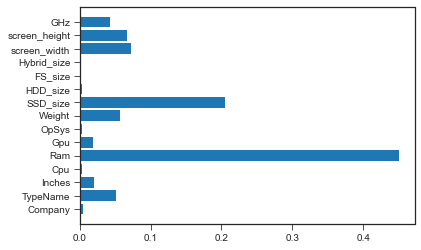

In [ ]:
plt.barh(features,imp)


In the Extra trees model, the most important variable is the same as in the Random Forest model.

<h2>XGBoost</h2>

In [ ]:
import xgboost as xgb
xgb.set_config(verbosity=0)
import time 
from operator import itemgetter

def run_xgb(train, validate, features, target, # mandatory arguments
            eta=0.03, max_depth=10, subsample = 0.7, colsample_bytree = 0.7, # parameters
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # parameters
            rate_drop = 0.2, skip_drop=0.5, # parameters
            num_boost_round = 1000, early_stopping_rounds = 50, # parameters
            debug=True, eval_metric= ["rmse"], objective = "reg:squarederror", # config
            seed=2021, booster = "gbtree", tree_method="gpu_hist", grow_policy="depthwise", silent = True): # config
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Creating a dictionary to submit to the XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatic transfer of the number of classes for multiple classification levels
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    
    params["lambda"]=lambdaX
    
    #  Transforming sets to DMatrix structure       
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Creating a list of collections for evaluation
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Create a dictionary variable to pass
    train_history = dict()

    # Running the training algorithm
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug) 
    
    # Statistics
    score = gbm.best_score

    # Convert training history to Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Record the predicted values for the validation set for the best (from a validation point of view) iteration
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Prepare a sorted list for variable validity, instead of a dictionary
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Built-in visualization of variables
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [ ]:
def CVTestXGB(nFolds = 5, randomState=2022, features=features, debug=False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    RMSEtestResults = []
    RMSEtrainResults = []
    MSEtestResults = []
    MSEtrainResults = []
    MAEtestResults = []
    MAEtrainResults = []

    predictions = []
    
    indices = []
    
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, silent=True, *args, **kwargs)

        predictions.append(testPred.tolist().copy())
        
        indices.append(df.iloc[test].index.tolist().copy())
        
        RMSEtrainScore = np.log(mean_squared_error(df[target].iloc[train], trainPred))
        RMSEtestScore = np.log(mean_squared_error(df[target].iloc[test], testPred))
        MAEtrainScore = mean_absolute_error(df[target].iloc[train], trainPred)
        MAEtestScore = mean_absolute_error(df[target].iloc[test], testPred)
        MSEtrainScore = mean_squared_error(df[target].iloc[train], trainPred)
        MSEtestScore = mean_squared_error(df[target].iloc[test], testPred)

        RMSEtrainResults.append(RMSEtrainScore)
        RMSEtestResults.append(RMSEtestScore)
        MAEtrainResults.append(MAEtrainScore)
        MAEtestResults.append(MAEtestScore)
        MSEtrainResults.append(MSEtrainScore)
        MSEtestResults.append(MSEtestScore)

        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return RMSEtrainResults, RMSEtestResults,MAEtrainResults,MAEtestResults, MSEtrainResults,MSEtestResults,predictions, indices, pd.concat(hists, axis=1), imp

In [ ]:
import random
xgb.set_config(verbosity=0)

results=[]
paramList = []
for x in range(100):
    params = (random.randint(3, 10), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10))
    RMSEtrainResults, RMSEtestResults,MAEtrainResults,MAEtestResults, MSEtrainResults,MSEtestResults,predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4])
    #print(np.mean(RMSEtrainResults), params)
    results.append(np.mean(RMSEtrainResults))
    paramList.append(params)


In [ ]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=False)
for row in imp[0:5]:
    print(row)

(8.946705763988371, (10, 0.8703539413176373, 0.8306097181416295, 8.223081634258701, 9.002590220377073))
(8.956691192819662, (8, 0.779746924239969, 0.8682746674614744, 3.2088198362592655, 0.7500584994255832))
(9.039432548535451, (9, 0.7704606510098786, 0.8958032269505661, 5.721962602222782, 2.7348870290751))
(9.191919871421725, (9, 0.6278219202183093, 0.6559847726967794, 3.8732071642502985, 9.21170968892032))
(9.283230719349543, (9, 0.6988383135532102, 0.48500075297138323, 1.5828070214608247, 8.538664430836702))


In [ ]:
RMSEtrainResults, RMSEtestResults,MAEtrainResults,MAEtestResults, MSEtrainResults,MSEtestResults,predictions, indices, hists, imp = CVTestXGB(
    max_depth=10,
    subsample = 0.8703539413176373,
    colsample_bytree = 0.8306097181416295,
    lambdaX=8.223081634258701,
    gamma=9.002590220377073)

In [ ]:
fold1 = ['XGBoost', '1 Fold', MAEtrainResults[0], MAEtestResults[0], MSEtrainResults[0], MSEtestResults[0], RMSEtrainResults[0], RMSEtestResults[0]]
fold2 = ['XGBoost', '2 Fold', MAEtrainResults[1], MAEtestResults[1], MSEtrainResults[1], MSEtestResults[1], RMSEtrainResults[1], RMSEtestResults[1]]
fold3 = ['XGBoost', '3 Fold', MAEtrainResults[2], MAEtestResults[2], MSEtrainResults[2], MSEtestResults[2], RMSEtrainResults[2], RMSEtestResults[2]]
fold4 = ['XGBoost', '4 Fold', MAEtrainResults[3], MAEtestResults[0], MSEtrainResults[3], MSEtestResults[3], RMSEtrainResults[3], RMSEtestResults[3]]
fold5 = ['XGBoost', '5 Fold', MAEtrainResults[4], MAEtestResults[4], MSEtrainResults[4], MSEtestResults[4], RMSE_trainResults[4], RMSEtestResults[4]]
mean = ['XGBoost', 'Mean', np.mean(MAEtrainResults),  np.mean(MAEtestResults), np.mean(MSEtrainResults), np.mean(MSEtestResults), np.mean(RMSEtrainResults), np.mean(RMSEtestResults)]
df_results_XGB = pd.DataFrame([fold1, fold2, fold3, fold4, fold5, mean], columns=['Model', 'Folds', 'MAE Train', 'MAE Test', 'MSE Train', 'RMSE Test', 'RMSE Train', 'RMSE Test'])
#results = pd.concat([results, df_results_XGB])
df_results_XGB.set_index('Model')

,Folds,MAE Train,MAE Test,MSE Train,RMSE Test,RMSE Train,RMSE Test
Model,,,,,,,
XGBoost,1 Fold,73.952506,188.072834,11305.611985,81078.947744,9.333055,11.303179
XGBoost,2 Fold,77.432414,170.713747,12545.669291,70921.618397,9.437131,11.169331
XGBoost,3 Fold,96.533361,160.458743,19314.452111,46325.689105,9.868609,10.743452
XGBoost,4 Fold,61.755275,188.072834,8587.892068,96507.829866,9.058109,11.477379
XGBoost,5 Fold,67.650766,153.820362,9933.905309,58754.546626,11.548466,10.981124
XGBoost,Mean,75.464865,174.000889,12337.506153,70717.726348,9.380122,11.134893


<BarContainer object of 15 artists>

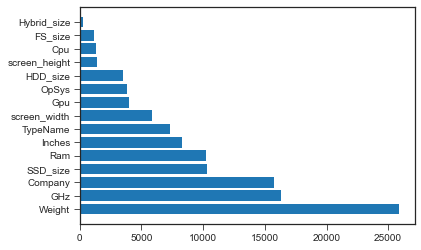

In [ ]:
feat = []
val = []
for x in imp:
    feat.append(x[0])
    val.append(x[1])
    
plt.barh(feat,val)


The features importance for XGBoost is much different than for previous models. For the XGBoost model, the most important variable is weight, followed by number of gigahertz and company. Frame size is not as important as in previous models.

<h2>Feed Forward Neural Networks</h2>

In [ ]:
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers.advanced_activations import PReLU


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


In [ ]:
# Auxiliary function
def actModel(model, activation):
    if activation=='prelu':
        model.add(keras.layers.advanced_activations.PReLU(weights=None, alpha_initializer="zero"))
    else:
        model.add(Activation(activation))
    return


# Network building function.
def create_network(n=3, nu1=10, nu2=5, nu3=5,
                   activation='relu',
                   dropout=Dropout,
                   dropout_rate=0,
                   regu=0,
                   kernel_initializer='lecun_normal',
                   optimizer='SGD',
                   num_classes=1, 
                  inputShape=10, dropout_all_layers = False, debug=False, *args, **kwargs):
    nu=[nu1, nu2, nu3]
    
    #Calling the model    
    model = Sequential()
    
   #Definition of value to network
    model.add(Dense(nu[0],input_shape=(inputShape,),
                    kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(regu)))
    
    # Adding activation functionality to the first layer.
    actModel(model, activation)
    
    # Dropout
    if dropout_rate > 0.01:
        model.add(dropout(dropout_rate))
    
    # Loop to build more layers
    for i in range(1, n):
        model.add(Dense(nu[i], kernel_initializer=kernel_initializer))
        # activate function
        actModel(model, activation)
        
        # Dropouts
        if dropout_rate > 0.01 and dropout_all_layers:
            model.add(dropout(dropout_rate))
            
    #deafult loss funcion - MSE
    model.add(Activation('softmax'))
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

In [ ]:
def net(train, test, features_nn, target, epochs = 30, batchSize=100, debug=False, *args, **kwargs):
    
    # Prepare sets
    y_train = train[target].values
    y_test = test[target].values
    x_train = train[features_nn].values
    x_test = test[features_nn].values
    
    num_classes = y_train.shape
    
    if debug:
        print('Loading data...')
        print(len(x_train), 'train sequences')
        print(len(x_test), 'test sequences')
        print(num_classes, 'classes')
        print('x_train shape:', x_train.shape)
        print('x_test shape:', x_test.shape)
        print('\nBuilding network 1...')
    
    # Create model.
    model = create_network(num_classes=num_classes, inputShape=x_train.shape[1], debug=debug, *args, **kwargs)
    
    # Prepare data to training statistics
    history_model = dict()
    loss = []
    valLoss = []
    acc = []
    valAcc = []
    auc = []
    valAuc = []
    
    
    bestTrainProba = []
    bestTestProba = []
    bestAuc = 0
    for z in range(epochs):
        # Learning
        histModel = model.fit(x_train,
                                    y_train,
                                    batch_size=batchSize,
                                    epochs=1,
                                    verbose=debug,
                                    validation_split=0.0,
                                   validation_data=(x_test, y_test))
        # Predictions
        probaTrain = model.predict(x_train,
                                       batch_size=y_train.shape[0],
                                       verbose=debug)
        probaTest = model.predict(x_test,
                                       batch_size=y_test.shape[0],
                                       verbose=debug)
        # Statistics
        aucTrain = mean_absolute_error(train[target], probaTrain[:,1])
        aucTest = mean_absolute_error(test[target], probaTest[:,1])
        if debug:
            print(aucTrain, aucTest)
            
        # The best iteration
        if aucTest>bestAuc:
            bestAuc = aucTest
            bestTrainProba = probaTrain[:, 1].tolist()
            bestTestProba = probaTest[:, 1].tolist()
        
        # Save iteration results
        loss.append(histModel.history['loss'][0])
        valLoss.append(histModel.history['val_loss'][0])
        acc.append(histModel.history['mse'][0])
        valAcc.append(histModel.history['mse'][0])
        auc.append(aucTrain)
        valAuc.append(aucTest)
        
    # Save all results to dictionary
    history_model['loss'] = loss
    history_model['valLoss'] = valLoss
    history_model['mse'] = acc
    history_model['valmse'] = valAcc
    history_model['rmse'] = auc
    history_model['valrmse'] = valAuc
    return max(valAuc), bestTrainProba, bestTestProba, history_model


In [ ]:
def CVTestNN(nFolds = 5, df=df_nn ,randomState=2022, features=features, debug=False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    MAEtestResults = []
    MAEtrainResults = []
    MSEtestResults = []
    MSEtrainResults = []
    RMSEtestResults = []
    RMSEtrainResults = []

    
    predictions = []
    
    indices = []
    
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        score, trainPred, testPred, history = net(df.iloc[train], df.iloc[test], features, target,
                                                            debug=False, *args, **kwargs)

        predictions.append(testPred.copy())
        
        indices.append(df.iloc[test].index.tolist().copy())
        
        MAEtrainScore = mean_absolute_error(df[target].iloc[train], trainPred)
        MAEtestScore = mean_absolute_error(df[target].iloc[test], testPred)
        MSEtrainScore = mean_squared_error(df[target].iloc[train], trainPred)
        MSEtestScore = mean_squared_error(df[target].iloc[test], testPred)
        RMSEtrainScore = np.log(mean_squared_error(df[target].iloc[train], trainPred))
        RMSEtestScore = np.log(mean_squared_error(df[target].iloc[test], testPred))

        MAEtrainResults.append(MAEtrainScore)
        MAEtestResults.append(MAEtestScore)
        MSEtrainResults.append(MSEtrainScore)
        MSEtestResults.append(MSEtestScore)
        RMSEtrainResults.append(RMSEtrainScore)
        RMSEtestResults.append(RMSEtestScore)

        
        hists.append(history)
        fold+=1
                
    return MAEtrainResults, MAEtestResults,MSEtrainResults,MSEtestResults, RMSEtrainResults,RMSEtestResults,predictions, indices, hists

In [ ]:
#Variables standarization
from sklearn.preprocessing import MinMaxScaler
data = df_nn[['Inches', 'Ram', 'GHz', 'SSD_size', 'HDD_size', 'FS_size', 'Hybrid_size','screen_width', 'screen_height']].values
scaler = MinMaxScaler()
scaler.fit(data)
df_scal = pd.DataFrame(scaler.transform(data), columns=['Inches', 'Ram', 'GHz', 'SSD_size', 'HDD_size', 'FS_size', 'Hybrid_size','screen_width', 'screen_height'])
df_cat = df_nn.reset_index().drop(columns=['Inches', 'Ram', 'GHz', 'SSD_size', 'HDD_size', 'FS_size', 'Hybrid_size','screen_width', 'index'])

df_nn = pd.concat([df_scal,df_cat] , axis=1)

In [ ]:
#Create new list of features (because there are dummy variables)
features_nn = list(df_nn.columns)
features_nn.remove('Price_euros')

In [ ]:
res2 = {}
for x in range(100):
    opti = random.choice(["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"])
    acti = random.choice(["tanh", "sigmoid", "linear", "relu", "selu", "prelu"])
    lay = random.randint(2,3)
    neu1 = random.randint(10,100)
    neu2 = random.randint(10,100)
    neu3 = random.randint(10,100)
    dr = round(random.uniform(0,0.5),2)
    reg = round(random.uniform(0,0.3),2)
    dal = random.choice([False])
    batch=random.choice([0,20,50,100,200])
    MAEtrainResults, MAEtestResults,MSEtrainResults,MSEtestResults, RMSEtrainResults,RMSEtestResults,predictions, indices, hists = CVTestNN(features=features_nn, n=lay, nu1=neu1, nu2=neu2, nu3=neu3,
                                    epochs = 50, batchSize=batch, optimizer=opti, activation=acti,
                                     dropout_rate=dr, dropout_all_layers=dal, df=df_nn ,regu=reg, debug=False)
    
    res2[np.mean(RMSEtestResults)] = {
        'TrainResults': np.mean(RMSEtrainResults),
        'optimizer': opti,
        'activation':acti,
        'layers': lay,
        'n1': neu1,
        'n2': neu2,
        'n3': neu3,
        'drop_rate':dr,
        'regularization': reg,
        'dropout_all': dal,
        'batchsize': batch
    }    
print(min(res2.keys()))
print(res2[min(res2.keys())])

14.370404892608596
{'TrainResults': 14.375634593587005, 'optimizer': 'Adamax', 'activation': 'prelu', 'layers': 3, 'n1': 82, 'n2': 69, 'n3': 29, 'drop_rate': 0.12, 'regularization': 0.0, 'dropout_all': False, 'batchsize': 50}


In [ ]:
MAEtrainResults, MAEtestResults,MSEtrainResults,MSEtestResults, RMSEtrainResults,RMSEtestResults,predictions, indices, hists = CVTestNN(features=features_nn, n=3, nu1=82, nu2=69, nu3=29,
                                epochs = 50, batchSize=50, optimizer='Adamax', activation='prelu',
                                 dropout_rate=0.12, dropout_all_layers=False, df=df_nn ,regu=0.12, debug=False)


In [ ]:
fold1 = ['Neural Network', '1 Fold', MAEtrainResults[0], MAEtestResults[0],MSEtrainResults[0], MSEtestResults[0], RMSEtrainResults[0], RMSEtestResults[0]]
fold2 = ['Neural Network', '2 Fold', MAEtrainResults[1], MAEtestResults[1],MSEtrainResults[1], MSEtestResults[1], RMSEtrainResults[1], RMSEtestResults[1]]
fold3 = ['Neural Network', '3 Fold', MAEtrainResults[2], MAEtestResults[2],MSEtrainResults[2], MSEtestResults[2], RMSEtrainResults[2], RMSEtestResults[2]]
fold4 = ['Neural Network', '4 Fold', MAEtrainResults[3], MAEtestResults[0],MSEtrainResults[3], MSEtestResults[3], RMSEtrainResults[3], RMSEtestResults[3]]
fold5 = ['Neural Network', '5 Fold', MAEtrainResults[4], MAEtestResults[4],MSEtrainResults[4], MSEtestResults[4], RMSEtrainResults[4], RMSEtestResults[4]]
mean = ['Neural Network', 'Mean', np.mean(MAEtrainResults),  np.mean(MAEtestResults), np.mean(MSEtrainResults), np.mean(MSEtestResults), np.mean(RMSEtrainResults), np.mean(RMSEtestResults)]
df_results_NN = pd.DataFrame([fold1, fold2, fold3, fold4, fold5, mean], columns=['Model', 'Folds', 'MAE Train', 'MAE Test', 'MSE Train', 'RMSE Test', 'RMSE Train', 'RMSE Test'])
#results = pd.concat([results, df_results_NN])
df_results_NN.set_index('Model')

,Folds,MAE Train,MAE Test,MSE Train,RMSE Test,RMSE Train,RMSE Test
Model,,,,,,,
Neural Network,1 Fold,1108.600077,1185.641648,1.683659e+06,2.024191e+06,14.336480,14.520681
Neural Network,2 Fold,1130.051066,1100.084253,1.772631e+06,1.669326e+06,14.387975,14.327931
Neural Network,3 Fold,1137.551631,1069.909038,1.822026e+06,1.470969e+06,14.415460,14.201432
Neural Network,4 Fold,1118.506660,1185.641648,1.743545e+06,1.785495e+06,14.371431,14.395206
Neural Network,5 Fold,1125.500979,1118.204346,1.737705e+06,1.808901e+06,14.368076,14.408230
Neural Network,Mean,1124.042083,1124.014942,1.751913e+06,1.751776e+06,14.375884,14.370696


<h2>Results</h2>

In [ ]:
results.set_index(['Model', 'Folds'])

MAE Train     MAE Test     MSE Train     RMSE Test  \
Model          Folds                                                          
Random Forest  1 Fold   167.722876   228.359070  6.029656e+04  1.183186e+05   
               2 Fold   174.357112   198.298703  6.552406e+04  9.198037e+04   
               3 Fold   174.400718   188.770109  6.768288e+04  6.552189e+04   
               4 Fold   166.277616   228.359070  5.900825e+04  1.319690e+05   
               5 Fold   172.901435   193.868172  6.658471e+04  9.091794e+04   
               Mean     171.131952   209.553527  6.381929e+04  9.974156e+04   
Extra Trees    1 Fold   210.442947   253.833995  9.818133e+04  1.589667e+05   
               2 Fold   217.943238   229.952183  1.060394e+05  1.153649e+05   
               3 Fold   218.493810   210.142824  1.081763e+05  7.926694e+04   
               4 Fold   207.636914   253.833995  9.517251e+04  1.398846e+05   
               5 Fold   217.784900   219.157043  1.036180e+05  1.196879e+05   
               Mean     214.460362   234.238266  1.022375e+05  1.226342e+05   
XGBoost        1 Fold    40.326230   187.962167  4.338742e+03  8.034664e+04   
               2 Fold    82.393714   166.900580  1.550168e+04  6.800206e+04   
               3 Fold    89.447521   163.129467  1.903438e+04  4.824314e+04   
               4 Fold    44.197307   187.962167  5.568980e+03  9.937020e+04   
               5 Fold    32.854784   153.217415  3.753771e+03  5.792861e+04   
               Mean      57.843911   174.511267  9.639511e+03  7.077813e+04   
Neural Network 1 Fold  1108.600077  1185.641648  1.683659e+06  2.024191e+06   
               2 Fold  1130.051066  1100.084253  1.772631e+06  1.669326e+06   
               3 Fold  1137.551631  1069.909038  1.822026e+06  1.470969e+06   
               4 Fold  1118.506660  1185.641648  1.743545e+06  1.785495e+06   
               5 Fold  1125.500979  1118.204346  1.737705e+06  1.808901e+06   
               Mean    1124.042083  1124.014942  1.751913e+06  1.751776e+06   

                       RMSE Train  RMSE Test  
Model          Folds                          
Random Forest  1 Fold   11.007030  11.681136  
               2 Fold   11.090173  11.429330  
               3 Fold   11.122589  11.090140  
               4 Fold   10.985433  11.790322  
               5 Fold   11.106230  11.417713  
               Mean     11.062291  11.481728  
Extra Trees    1 Fold   11.494571  11.976450  
               2 Fold   11.571566  11.655855  
               3 Fold   11.591517  11.280576  
               4 Fold   11.463446  11.848573  
               5 Fold   11.548466  11.692643  
               Mean     11.533913  11.690819  
XGBoost        1 Fold    8.375340  11.294106  
               2 Fold    9.648703  11.127293  
               3 Fold    9.854002  10.784009  
               4 Fold    8.624967  11.506608  
               5 Fold   11.548466  10.966967  
               Mean      8.946706  11.135796  
Neural Network 1 Fold   14.336480  14.520681  
               2 Fold   14.387975  14.327931  
               3 Fold   14.415460  14.201432  
               4 Fold   14.371431  14.395206  
               5 Fold   14.368076  14.408230  
               Mean     14.375884  14.370696

The best model in terms of all metrics is XGBoost. The worst performing of all models is neural networks. Despite the high performance of XGBoost, there is model overtraining on it. In this case, the most optimal model to choose is Random Forest. In contrast, Extra Trees does not perform significantly worse than this model.